## Import Libraries

In [1]:
# import data analysis-related libraries
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import math
from wordcloud import WordCloud

# text data processing
import re
from nltk.corpus import stopwords
import spacy
from collections import Counter


## Data Loading and Cleaning

In [2]:
# read the cleaned dataset
cleaned_dataset = pd.read_csv("final_cleaned_data.csv")
cleaned_dataset.head()

,link,name,price,rating,total_sold,store_name,store_location,product_description,customer_satisfaction,IsRated,total_rating,num_reviews,review_rating_ratio,brand_name
0,https://www.tokopedia.com/samsung/samsung-gala...,Samsung Galaxy A05s 6/128GB,1999000.0,2.5,8000,Samsung Official Store,Jakarta,"""awesome offers! - free travel adapter 25w sen...",99.0,False,4155.0,1475.0,0.354994,Samsung
1,https://www.tokopedia.com/samsung/samsung-gala...,Samsung Galaxy A25 5G 8/256GB,4049000.0,2.5,750,Samsung Official Store,Jakarta,spesifikasi -processor : octa-core -size : 6.5...,98.0,False,438.0,169.0,0.385845,Samsung
2,https://www.tokopedia.com/distriponsel/xiaomi-...,Xiaomi Redmi 14C 8/256 GB 6/128 GB Redmi 14 C ...,1385000.0,2.5,500,Distributor Ponsel,Jakarta,"untuk produk xiaomi, vivo, realme, oppo, samsu...",98.0,False,206.0,78.0,0.378641,VIVO
3,https://www.tokopedia.com/tecnoofficialstore/t...,"TECNO POVA 6 - 12+12GB*+256GB, 70W Ultra Charg...",2769000.0,2.5,500,Tecno Official Store,Jakarta,keunggulan: mediatek helio g99 ultimate 6nm 60...,98.0,False,371.0,169.0,0.455526,TECNO
4,https://www.tokopedia.com/tecnoofficialstore/t...,"TECNO SPARK 30C – 6+6GB*+128GB, 120Hz Display,...",1429000.0,2.5,250,Tecno Official Store,Jakarta,keunggulan: 48m main camera sony imx582 sensor...,97.0,False,150.0,77.0,0.513333,TECNO


#### Insight:
- apparently, there are still incorrect data content for IsRated column. some products have received some rating but still flagged as false since the rating data were not scraped and then filled by 2.5.
- to mitigate this issue, we need to replace isRated column with correct value and replace the 2.5 rating value with:
```equation
estimated rating = 4.5 * customer_satisfaction/100 + 2.5*(1-customer_satisfaction)/100
```
It is known that customer_satisfaction = proportion number of people rated 4-5 on the product.

In [3]:
# apparently, there are incorrect data filling process. so let's change it
# change True for non-zero total_rating
cleaned_dataset['IsRated'] = cleaned_dataset['total_rating'] != 0

# replace the default 2.5 rating value with new rating value
# Calculate the estimated rating for rows where Rating = 2.5
cleaned_dataset['new_rating'] = cleaned_dataset.apply(
    lambda row: (
        (4.5 * row['customer_satisfaction'] / 100) + (2.5 * (1 - row['customer_satisfaction'] / 100))
        if row['rating'] == 2.5
        else row['rating']
    ),
    axis=1
)

# show result
cleaned_dataset.head()


,link,name,price,rating,total_sold,store_name,store_location,product_description,customer_satisfaction,IsRated,total_rating,num_reviews,review_rating_ratio,brand_name,new_rating
0,https://www.tokopedia.com/samsung/samsung-gala...,Samsung Galaxy A05s 6/128GB,1999000.0,2.5,8000,Samsung Official Store,Jakarta,"""awesome offers! - free travel adapter 25w sen...",99.0,True,4155.0,1475.0,0.354994,Samsung,4.48
1,https://www.tokopedia.com/samsung/samsung-gala...,Samsung Galaxy A25 5G 8/256GB,4049000.0,2.5,750,Samsung Official Store,Jakarta,spesifikasi -processor : octa-core -size : 6.5...,98.0,True,438.0,169.0,0.385845,Samsung,4.46
2,https://www.tokopedia.com/distriponsel/xiaomi-...,Xiaomi Redmi 14C 8/256 GB 6/128 GB Redmi 14 C ...,1385000.0,2.5,500,Distributor Ponsel,Jakarta,"untuk produk xiaomi, vivo, realme, oppo, samsu...",98.0,True,206.0,78.0,0.378641,VIVO,4.46
3,https://www.tokopedia.com/tecnoofficialstore/t...,"TECNO POVA 6 - 12+12GB*+256GB, 70W Ultra Charg...",2769000.0,2.5,500,Tecno Official Store,Jakarta,keunggulan: mediatek helio g99 ultimate 6nm 60...,98.0,True,371.0,169.0,0.455526,TECNO,4.46
4,https://www.tokopedia.com/tecnoofficialstore/t...,"TECNO SPARK 30C – 6+6GB*+128GB, 120Hz Display,...",1429000.0,2.5,250,Tecno Official Store,Jakarta,keunggulan: 48m main camera sony imx582 sensor...,97.0,True,150.0,77.0,0.513333,TECNO,4.44


In [18]:
# save second version of cleaned data
# cleaned_dataset.to_csv("final_cleaned_data_v2.csv",index=False)

## Text Data Processing

### Initial WordCloud Generation
- to see the original word frequency in product description

In [4]:
# show initial most frequent text in product_description
combined_text = " ".join(cleaned_dataset['product_description'])

# process text by removing punctuation and conversion to lowercase
basic_processed_text = re.sub(r'[^\w\s]','',combined_text).lower()

In [6]:
print(basic_processed_text)

awesome offers  free travel adapter 25w senilai rp299000  free youtube premium 2 bulan syarat  ketentuan berlaku klaim melalui aplikasi samsung gift indonesia selama persediaan masih ada spesifikasi   processor  snapdragon 680  size  67  technology  pls lcd 90 hz  resolution  fhd  rear camera resolution  50mp  2mp  2mp  main camera auto focus  yes  rear camera  ois  no  rear camera  zoom  digital zoom up to 10x  front camera resolution  130 mp  front camera auto focus  no  video resolution  fhd 1920 x 108030fps  ram  6gb  rom  128gb  sim tray  dualsim  network type 4g  usb interface  data cable c to c  usb version  usb 20  earjack  yes  bluetooth version  bluetooth v51  nfc  no  battery capacity  5000mah 25w fast charging support  side fingerprint  yes spesifikasi processor  octacore size  65 technology  super amoled 120hz resolution  fhd rear camera resolution  500 mp  80 mp  20 mp main camera auto focus  yes rear camera  ois  yes rear camera  zoom  digital zoom up to 10x front camera

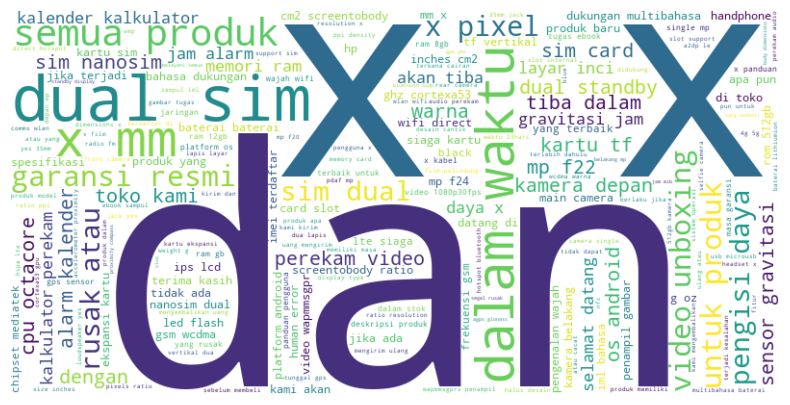

In [5]:
# show in word cloud
initial_wordcloud = WordCloud(width=800,height=400,background_color='white').generate(basic_processed_text)
plt.figure(figsize=(10,5))
plt.imshow(initial_wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

#### Insight:
- there are some irrelevant words such as 'dan' = and, 'selamat datang' = welcome, big letter X, 'toko kami' = our store, 'semua produk' = all products.
- let's remove theses words first.


### Removing Irrelevant Words

In [106]:
# create function for processing data based on list of irrelevant words
def word_filter(irrelevant_words,input_text):
    # split
    split_text = input_text.split()
    filtered_words = [word for word in split_text if word not in irrelevant_words]
    filtered_text_result = " ".join(filtered_words)
    return filtered_text_result
    

In [107]:
# wordcloud generator
def wordcloud_generator(filtered_text_result):
    wordcloud = WordCloud(width=800,height=400,background_color='white').generate(filtered_text_result)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

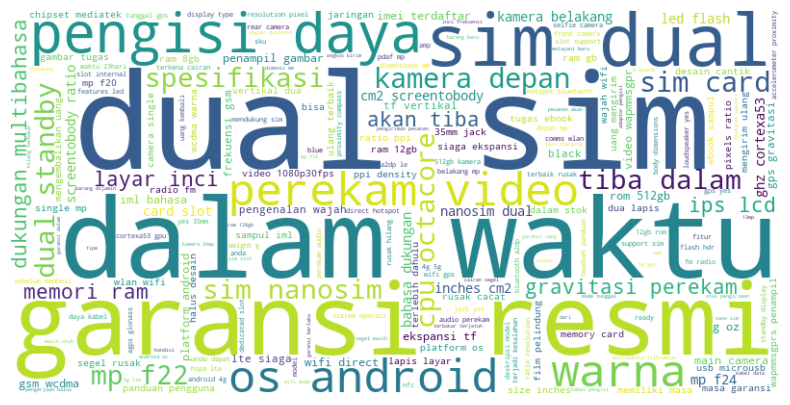

In [108]:
# create word filter to remove the irrelevant words
irrelevant_words = ['atau',"dengan", "dan", "di", "pada", "untuk", "yang", "adalah", "ini", "itu",'selamat','datang','X','x','hp','toko','kami','semua','produk','unboxing','handphone','apa','jika',
                    'pun','tidak','ada','terima','kasih','oppo','jam','human', 'error',"baterai","sensor",'kartu','jam','alarm','kalkulator','kalender','vivo']

# filter text
filtered_text = word_filter(irrelevant_words,basic_processed_text)

# visualize output
wordcloud_generator(filtered_text)



#### Insight:
There are still some redundant words:
1. dual sim = sim dual
2. sim nanosim = nanosim dual
3. perekam video = perekam
4. sim card = kartu sim
5. multibahasa = dukungan multibahasa
6. ekspansi kartu = kartu ekspansi
7. front kamera = kamera depan

We need to unify the terminologies to let other important features emerge in wordcloud.

### Standardize Keywords

In [112]:
def standardize_text(text, mappings):
    """
    Standardizes redundant words and phrases in the text based on the provided mappings.

    Args:
        text (str): The input text to standardize.
        mappings (dict): A dictionary of redundant words/phrases and their standardized terms.

    Returns:
        str: The standardized text.
    """
    # Normalize whitespace (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text.strip())
    # Convert text to lowercase for case-insensitive matching
    text = text.lower()
    
    # Sort mappings by length of the redundant phrase (longer phrases first)
    sorted_mappings = sorted(mappings.items(), key=lambda x: len(x[0]), reverse=True)
    
    # Replace redundant phrases with standardized terms
    for redundant, standard in sorted_mappings:
        text = text.replace(redundant.lower(), standard.lower())
    
    return text

In [113]:
# Sample text
text = "wajah pengenalan wajah face recognition"

# Standardize the text
standarized_text = standardize_text(text, mappings)
print("Standardized Text:", standarized_text)

Standardized Text: wajah pengenalan_wajah pengenalan_wajah


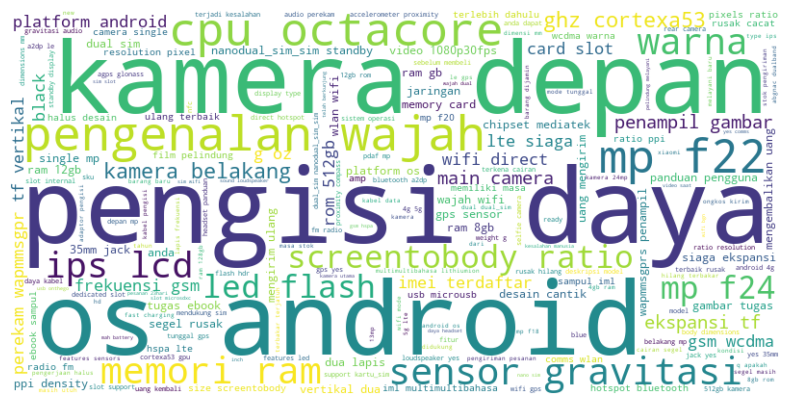

In [115]:
# Mapping of redundant words to standardized terms
mappings = {
    "sim dual": "dual_sim",
    "sim nanosim": "nanosim",
    "nanosim dual": "nanodual_sim",
    "sim nanodual": "nanodual_sim",
    "perekam video": "perekam",
    "sim card": "kartu_sim",
    "multibahasa": "multibahasa",
    "multi-bahasa": "multibahasa",
    "bahasa multibahasa":"multibahasa",
    "dukungan multibahasa":"multibahasa",
    "bahasa":"multibahasa",
    "multimultibahasa":"multibahasa",
    "cpu octa-core":'cpu octacore',
    "octa-core":'cpu octacore',
    "ekspansi kartu": "kartu_ekspansi",
    "front camera": "kamera_depan",
    # "alarm": "jam alarm",
    # "alarm kalender": "kalender",
    # "kalender kalkulator":"kalkulator",
    "gravitasi perekam": "sensor gravitasi",
    "gravitasi kalender": "sensor gravitasi",
    "kartu kartu": "kartu",
    "sim sim": "sim",
    "pengenalan wajah": "pengenalan wajah",
    "face recognition": "pengenalan wajah"
}

# filter service keyword
service_words = ['dalam', 'waktu','garansi', 'resmi','spesifikasi','akan','tiba','bisa','layar','inci','inches','cm2']

# filter text
filtered_service_text = word_filter(service_words,filtered_text)

# define new variable
standarized_filtered_text = standardize_text(filtered_service_text,mappings)

# visualize output
wordcloud_generator(standarized_filtered_text)

In [121]:
# Keywords to search semantic meaning on original paragraph
# keywords = ['android']

# # Find sentences containing the keywords
# for desc in cleaned_dataset['product_description']:
#     for keyword in keywords:
#         if keyword in desc.lower():
#             print(f"Found '{keyword}' in: {desc}")

#### Insight:
Final features that these smartphones usually have:
1. kamera depan = front camera
2. pengisian daya = 
3. perekam video = perekam
4. sim card = kartu sim
5. multibahasa = dukungan multibahasa
6. ekspansi kartu = kartu ekspansi
7. front kamera = kamera depan

We need to unify the terminologies to let other important features emerge in wordcloud.

## Other Exploratory Data Analysis